## Polarización y estabilidad


### Imports y configuracion inicial 

In [9]:
# ==================== IMPORTS ====================
import os
import numpy as np
import pandas as pd
import skrf as rf

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

### Parametros fijos y constantes del sistema

In [10]:
# ==================== CONSTANTES ====================
er = 4.5   # Constante dieléctrica del sustrato (por ejemplo FR4)
H = 1.66    # Espesor del dieléctrico en mm
c= 3e8    # Velocidad de la luz en m/s
f = 2.2e9  # Frecuencia objetivo en Hz
t = 0.04  # Espesor de la microtira en mm
lambd = c / f  # Longitud de onda en m
Z0 = 50  # Impedancia característica



### Carga de datos 

In [11]:
# Ruta de la carpeta que contiene los archivos .s2p
s2p_folder = "Users\magda\OneDrive\Documentos\EA!!!\Tp\BFP450"
# Obtener la lista de archivos .s2p en la carpeta
target_freq_ghz = 2.200


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\magda\AppData\Local\Temp\ipykernel_18272\1023869094.py:2: SyntaxWarning: invalid escape sequence '\m'
  s2p_folder = "Users\magda\OneDrive\Documentos\EA!!!\Tp\BFP450"


### Calculo parametros de estabilidad

In [12]:
# ==================== FUNCIONES ====================
def rollet_k(S):
    S11, S21, S12, S22 = S[0, 0], S[1, 0], S[0, 1], S[1, 1]
    delta = S11 * S22 - S12 * S21
    k_num = 1 - abs(S11)**2 - abs(S22)**2 + abs(delta)**2
    k_den = 2 * abs(S12 * S21)
    K = k_num / k_den if k_den != 0 else 0
    return K, delta, S21, S12, S11, S22

def calcular_coeficientes_refleccion(S11, S22, S12, S21, delta):
    B1 = 1 + abs(S11)**2 - abs(S22)**2 - abs(delta)**2
    B2 = 1 + abs(S22)**2 - abs(S11)**2 - abs(delta)**2
    C1 = S11 - delta * np.conj(S22)
    C2 = S22 - delta * np.conj(S11)

    rho_in_m = np.conj((B1 - np.sqrt(B1**2 - 4 * abs(C1)**2)) / (2 * C1))
    rho_out_m = np.conj((B2 - np.sqrt(B2**2 - 4 * abs(C2)**2)) / (2 * C2))

    Zin = Z0 * (1 + rho_in_m) / (1 - rho_in_m)
    Zout = Z0 * (1 + rho_out_m) / (1 - rho_out_m)

    return rho_in_m, rho_out_m, Zin, Zout

def calcular_microtira(Z0, er, H):
    A = Z0 / 60 * np.sqrt((er + 1) / 2) + ((er - 1) / (er + 1)) * (0.23 + 0.11 / er)
    B = 377 * np.pi / (2 * Z0 * np.sqrt(er))

    W_H5 = 8 * np.exp(A) / (np.exp(2 * A) - 2)
    W_H6 = 2 / np.pi * (B - 1 - np.log(2 * B - 1) + (er - 1) / (2 * er) * (np.log(B - 1) + 0.39 - 0.61 / er))

    W_H = W_H5 if W_H5 <= 2 else W_H6
    W = W_H * H

    if W_H <= (1 / (2 * np.pi)):
        Weff = W + (t / np.pi) * (1 + np.log(4 * np.pi * W / t))
    else:
        Weff = W + (t / np.pi) * (1 + np.log(2 * H / t))

    if W_H <= 1:
        erp = ((er + 1) / 2) + ((er - 1) / 2) * (1 / np.sqrt(1 + 12 * (H / W)) + 0.04 * (1 - W_H)**2)
        z0 = 60 / np.sqrt(erp) * np.log(8 * H / W + 0.25 * (W / H))
    else:
        erp = ((er + 1) / 2) + ((er - 1) / 2) * (1 / np.sqrt(1 + 12 * (H / W)))
        z0 = 120 * np.pi / np.sqrt(erp) / (W / H + 1.393 + 0.667 * np.log(W / H + 1.444))

    return W_H, z0, erp, Weff


### Circulos de estabilidad

Archivo cargado: C:\Users\magda\OneDrive\Documentos\GitHub\labo2_EA_III_Ampl_Microondas\BFP450\BFP450_w_noise_VCE_4.0V_IC_40mA.s2p
K: 1.107, Delta: 0.263-0.516j


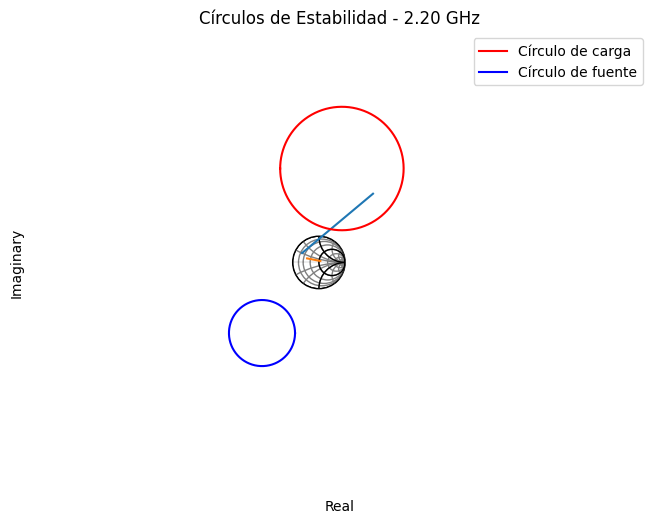

In [13]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt

# === Configuración ===
archivo_s2p = r'C:\Users\magda\OneDrive\Documentos\GitHub\labo2_EA_III_Ampl_Microondas\BFP450\BFP450_w_noise_VCE_4.0V_IC_40mA.s2p'
frecuencia_objetivo = 2.2e9  # Hz

# === Carga del archivo y red ===
ntw = rf.Network(archivo_s2p)
print(f"Archivo cargado: {archivo_s2p}")

# Índice de frecuencia más cercana
idx_frec = np.argmin(np.abs(ntw.f - frecuencia_objetivo))

# Extraer S-parameters
s = ntw.s[idx_frec, :, :]
s11, s12, s21, s22 = s[0, 0], s[0, 1], s[1, 0], s[1, 1]

# === Parámetros de estabilidad ===
delta = s11 * s22 - s12 * s21
K = (1 - abs(s11)**2 - abs(s22)**2 + abs(delta)**2) / (2 * abs(s12 * s21))
print(f"K: {K:.3f}, Delta: {delta:.3f}")

# === Círculo de carga ===
Cl = (np.conj(s22) - delta * np.conj(s11)) / (abs(s22)**2 - abs(delta)**2)
rl = abs(s12 * s21) / (abs(s22)**2 - abs(delta)**2)

# === Círculo de fuente ===
Cs = (np.conj(s11) - delta * np.conj(s22)) / (abs(s11)**2 - abs(delta)**2)
rs = abs(s12 * s21) / (abs(s11)**2 - abs(delta)**2)

# === Graficar ===
fig, ax = plt.subplots(figsize=(8, 6))
rf.plotting.plot_smith(ax=ax, s=s)

# Función para trazar un círculo
def trazar_circulo(ax, centro, radio, color, etiqueta):
    t = np.linspace(0, 2*np.pi, 500)
    puntos = centro + radio * np.exp(1j * t)
    ax.plot(np.real(puntos), np.imag(puntos), color=color, label=etiqueta)

trazar_circulo(ax, Cl, rl, 'red', 'Círculo de carga')
trazar_circulo(ax, Cs, rs, 'blue', 'Círculo de fuente')

ax.set_title(f'Círculos de Estabilidad - {ntw.f[idx_frec]/1e9:.2f} GHz')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.legend()
plt.grid(True)
plt.axis('equal')
plt.show()